In [31]:
import sys, os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from core.dataprovider import DataProvider
from core.datachecker import DataChecker
from core.datavisualizer import DataVisualizer
from core.flowsolver import FlowSolver

# Path configuration
MainPath = os.path.join('.')
sys.path.insert(0, MainPath)
sys.path.insert(0, os.path.join(os.getcwd(), '.', 'lib', 'odym', 'modules'))

# ODYM classes
import ODYM_Classes as msc
import dynamic_stock_model as dsm

# For Ipython Notebook only
%matplotlib inline


# **********************************************
# * Step 1: Define parameters for the aiphoria *
# **********************************************
model_params = {
    # Path (either relative or absolute) to the Excel file that contains the data for Processes and Flows
    # Path to the Excel file that contains data for the Processes and Flows
    # Path can be either:
    #   relative path (e.g. "/data/data.xlsx") or
    #   absolute path (e.g. "C:\aiphoria\data\data.xlsx")
    "filename": "data/example_data.xlsx",


    # *************
    # * Processes *
    # *************
    # Name of the sheet in Excel file that contains data for Processes
    "sheet_name_processes": "Processes",

    # Column range that contains data for the Processes
    # The both starting and ending columns are included in the range
    # (e.g. "A:B" means columns A, B, and C)
    "column_range_processes": "B:R",

    # Number of rows to skip when reading sheet for Process data
    # Header line must be the first line read (in this case row 3 would contain the header)
    "skip_num_rows_processes": 2,


    # *********
    # * Flows *
    # *********
    # Name of the sheet in Excel file that contains data for Flows
    "sheet_name_flows": "Flows",

    # Column range that contains data for the Flows
    # Only the starting column is included in the range, not the ending column!
    # (e.g. "A:C" means columns A and B)
    "column_range_flows": "B:U",

    # Number of rows to skip when reading sheet for Flow data
    # Header line must be the first line read (in this case row 3 would contain the header)
    "skip_num_rows_flows": 2,


    # ********************
    # * Model parameters *
    # ********************
    # Starting year of the model, this needs to be found from the Excel file
    "year_start": 2021,

    # Ending year of the model, this can be extended as far as needed
    # The last existing year data is copied to the non-existing years
    # Last year is included in the time range
    "year_end": 2030,

    # Should the model detect year range automatically from file?
    # True overrides year_start and year_end values
    "detect_year_range": False,

    # Create virtual Processes and Flows
    # Creates missing flows for Processes that have imbalance of input and output flows
    # i.e. unreported flows
    "use_virtual_flows": False,
}

# *********************************************************************************
# * Step 2: Load the data from Excel file using model_parameters and DataProvider *
# *********************************************************************************
print("DataProvider: Reading data from file '{}'...".format(model_params["filename"]))
dataprovider = DataProvider(model_params)

# **********************************************************
# * Step 3: Check data integrity and build flow graph data *
# **********************************************************
print("Checking data integrity, detecting year range from file: {}".format(model_params["detect_year_range"]))
checker = DataChecker(dataprovider)
default_detect_year_range = model_params["detect_year_range"]
flowsolver_data = checker.build_flowsolver_data(model_params["year_start"], model_params["year_end"], detect_year_range=default_detect_year_range)
is_checker_ok, checker_messages = checker.check_for_errors()

# Something went wrong with DataChecker, show error messages and stop execution
if not is_checker_ok:
    for msg in checker_messages:
        print(msg)
    SystemExit(-1)

# Get the updated years from graph_data
years = flowsolver_data["years"]
print("Using year range {} - {}".format(years[0], years[-1]))

# *******************************************************************
# * Step 4: Solve flows for all timesteps using aiphoria FlowSolver *
# *******************************************************************
flowsolver = FlowSolver(flowsolver_data, use_virtual_flows=model_params["use_virtual_flows"])
flowsolver.solve_timesteps()

DataProvider: Reading data from file 'data/example_data.xlsx'...
Checking data integrity, detecting year range from file: False
Checking stock distribution types...
Checking stock distribution parameters...
Checking process total inflows and total outflows mismatches...
Using year range 2021 - 2030


True

In [32]:
# ***************************
# * Step 5: Initialize ODYM *
# ***************************

# Track solid wood equivalent and carbon. Dictionary of classifications enters the index table defined for the system. The index table lists all aspects needed and assigns a classification and index letter to each aspect.
model_classifications = {
    'Time': msc.Classification(Name='Time', Dimension='Time', ID=1, Items=years),
    'Element': msc.Classification(Name='Elements', Dimension='Element', ID=2, Items=['Solid wood equivalent', 'Carbon']),
}


# Get model time start, end, and duration:
model_time_start = int(min(model_classifications['Time'].Items))
model_time_end = int(max(model_classifications['Time'].Items))
model_duration = model_time_end - model_time_start

index_table = pd.DataFrame({'Aspect': ['Time', 'Element'],  # 'Time' and 'Element' must be present!
                            'Description': ['Model aspect "time"', 'Model aspect "Element"'],
                            'Dimension': ['Time', 'Element'],  # 'Time' and 'Element' are also dimensions
                            'Classification': [model_classifications[Aspect] for Aspect in ['Time', 'Element']],
                            'IndexLetter': ['t', 'e' ]})  # Unique one letter (upper or lower case) indices to be used later for calculations.

index_table.set_index('Aspect', inplace=True)  # Default indexing of IndexTable, other indices are produced on the fly
index_table

,Description,Dimension,Classification,IndexLetter
Aspect,,,,
Time,"Model aspect ""time""",Time,<ODYM_Classes.Classification object at 0x00000...,t
Element,"Model aspect ""Element""",Element,<ODYM_Classes.Classification object at 0x00000...,e


In [33]:
# **************************************
# * Step 6: Initialize ODYM MFA system *
# **************************************
mfa_system = msc.MFAsystem(Name='Wood product system', Geogr_Scope='Europe', Unit='Mm3',
                           ProcessList=[], FlowDict={}, StockDict={}, ParameterDict={},
                           Time_Start=model_time_start, Time_End=model_time_end, IndexTable=index_table,
                           Elements=index_table.loc['Element'].Classification.Items)

# Get inflow values to stock
year_index_to_year = dict(enumerate(years))
unique_processes = flowsolver.get_unique_processes()
unique_flows = flowsolver.get_unique_flows()

# DataFrames for Processes, Flows and Flow values
df_processes = flowsolver.get_processes_as_dataframe()
df_flows = flowsolver.get_flows_as_dataframe()
df_flow_values = flowsolver.get_evaluated_flow_values_as_dataframe()

# Create ODYM objects
odym_processes = []
process_id_to_index = {}
for process_id, process in flowsolver.get_unique_processes().items():
    process_index = len(odym_processes)
    process_id_to_index[process_id] = process_index
    new_process = msc.Process(ID=process_index, Name=process.name)
    odym_processes.append(new_process)

odym_flows = {}
for flow_id, flow in unique_flows.items():
    source_process_index = process_id_to_index[flow.source_process_id]
    target_process_index = process_id_to_index[flow.target_process_id]
    new_flow = msc.Flow(ID=flow.id, P_Start=source_process_index, P_End=target_process_index, Indices='t,e', Values=None)
    odym_flows[flow.id] = new_flow

odym_stocks = {}
for stock in flowsolver.get_all_stocks():
    process_index = process_id_to_index[stock.id]
    new_stock = msc.Stock(ID=stock.id, Name=stock.name, P_Res=process_index, Indices='t,e', Type=1, Values=None)
    odym_stocks[stock.id] = new_stock

mfa_system.ProcessList = odym_processes
mfa_system.FlowDict = odym_flows
mfa_system.StockDict = odym_stocks
mfa_system.Initialize_FlowValues()
mfa_system.Initialize_StockValues()
mfa_system.Consistency_Check()

# Update ODYM flow values from flow values DataFrame
for flow_id, flow in mfa_system.FlowDict.items():
    for year_index, value in enumerate(flow.Values):
        # NOTE: Virtual flows use default value defined in Flow for carbon content (now 1.0)
        solved_flow = flowsolver.get_flow(year=year_index_to_year[year_index], flow_id=flow_id)
        flow.Values[year_index, 0] = solved_flow.evaluated_value
        flow.Values[year_index, 1] = solved_flow.evaluated_value_carbon

# Refer to Pandas for more instructions on how to save DataFrame to file:
# Example: df.to_excel("filename.xlsx")


In [34]:
# *****************************************
# * Step 7: Show mass balance information *
# *****************************************

# Get mass balance from MFA system
mb = mfa_system.MassBalance()
sum_mb = np.abs(mb).sum(axis=0).sum(axis=1) # reports the sum of all absolute balancing errors by process for all years.
print("Mass balance shape (timesteps x processes x chemical elements): {}".format(mb.shape))

# Show process mass balances based, all years
print("Mass balance by Process, sum of all years")
cols = {"Process": [], "Mass balance": []}
for process_index, process_mass_balance in enumerate(sum_mb):
    process_name = odym_processes[process_index].Name
    cols["Process"].append(process_name)
    cols["Mass balance"].append(process_mass_balance)

df_mass_balances = pd.DataFrame(cols)
print(df_mass_balances)

Mass balance shape (timesteps x processes x chemical elements): (10, 9, 2)
Mass balance by Process, sum of all years
                Process  Mass balance
0  Industrial_roundwood      722.0544
1            Sawmilling        6.4888
2              Residues      231.9720
3              Sawnwood        8.4864
4          Construction        2.0736
5             Furniture        0.0000
6              Sawnwood      120.3424
7              Sawnwood      240.6848
8          Incineration      369.6640


In [35]:
# **************************************
# * Step 8: Create ODYM dynamic stocks *
# **************************************

# Convert flowgraph stocks to ODYM stocks

# Stock ID to Dynamic Stock model that tracks
stock_id_to_dsm_swe = {}
stock_id_to_dsm_carbon = {}
for stock in flowsolver.get_all_stocks():
    total_inflows_swe = []
    total_inflows_carbon = []

    # Gather values for all years
    for year in years:
        year_inflows_swe = flowsolver.get_process_inflows_total_swe(stock.id, year)
        year_inflows_carbon = flowsolver.get_process_outflows_total_carbon(stock.id, year)
        total_inflows_swe.append(year_inflows_swe)
        total_inflows_carbon.append(year_inflows_carbon)

    stock_lifetime_params = {
        'Type': stock.distribution_type,
        'Mean': [stock.lifetime],
        'StdDev': [stock.distribution_params] if isinstance(stock.distribution_params, list) else [stock.distribution_params],
        'Shape': [1.0], # TODO: Implement reading Weibull parameters inside datastructures.py
        'Scale': [1.0], # TODO: Implement reading Weibull parameters inside datastructures.py
    }

    dsm_swe = dsm.DynamicStockModel(t=np.array(years), i=total_inflows_swe, lt=stock_lifetime_params)
    stock_id_to_dsm_swe[stock.id] = dsm_swe

    dsm_carbon = dsm.DynamicStockModel(t=np.array(years), i=total_inflows_carbon, lt=stock_lifetime_params)
    stock_id_to_dsm_carbon[stock.id] = dsm_carbon
    print(stock_lifetime_params)



{'Type': 'Normal', 'Mean': array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10]), 'StdDev': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'Shape': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'Scale': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}
{'Type': 'Normal', 'Mean': array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5]), 'StdDev': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'Shape': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'Scale': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}


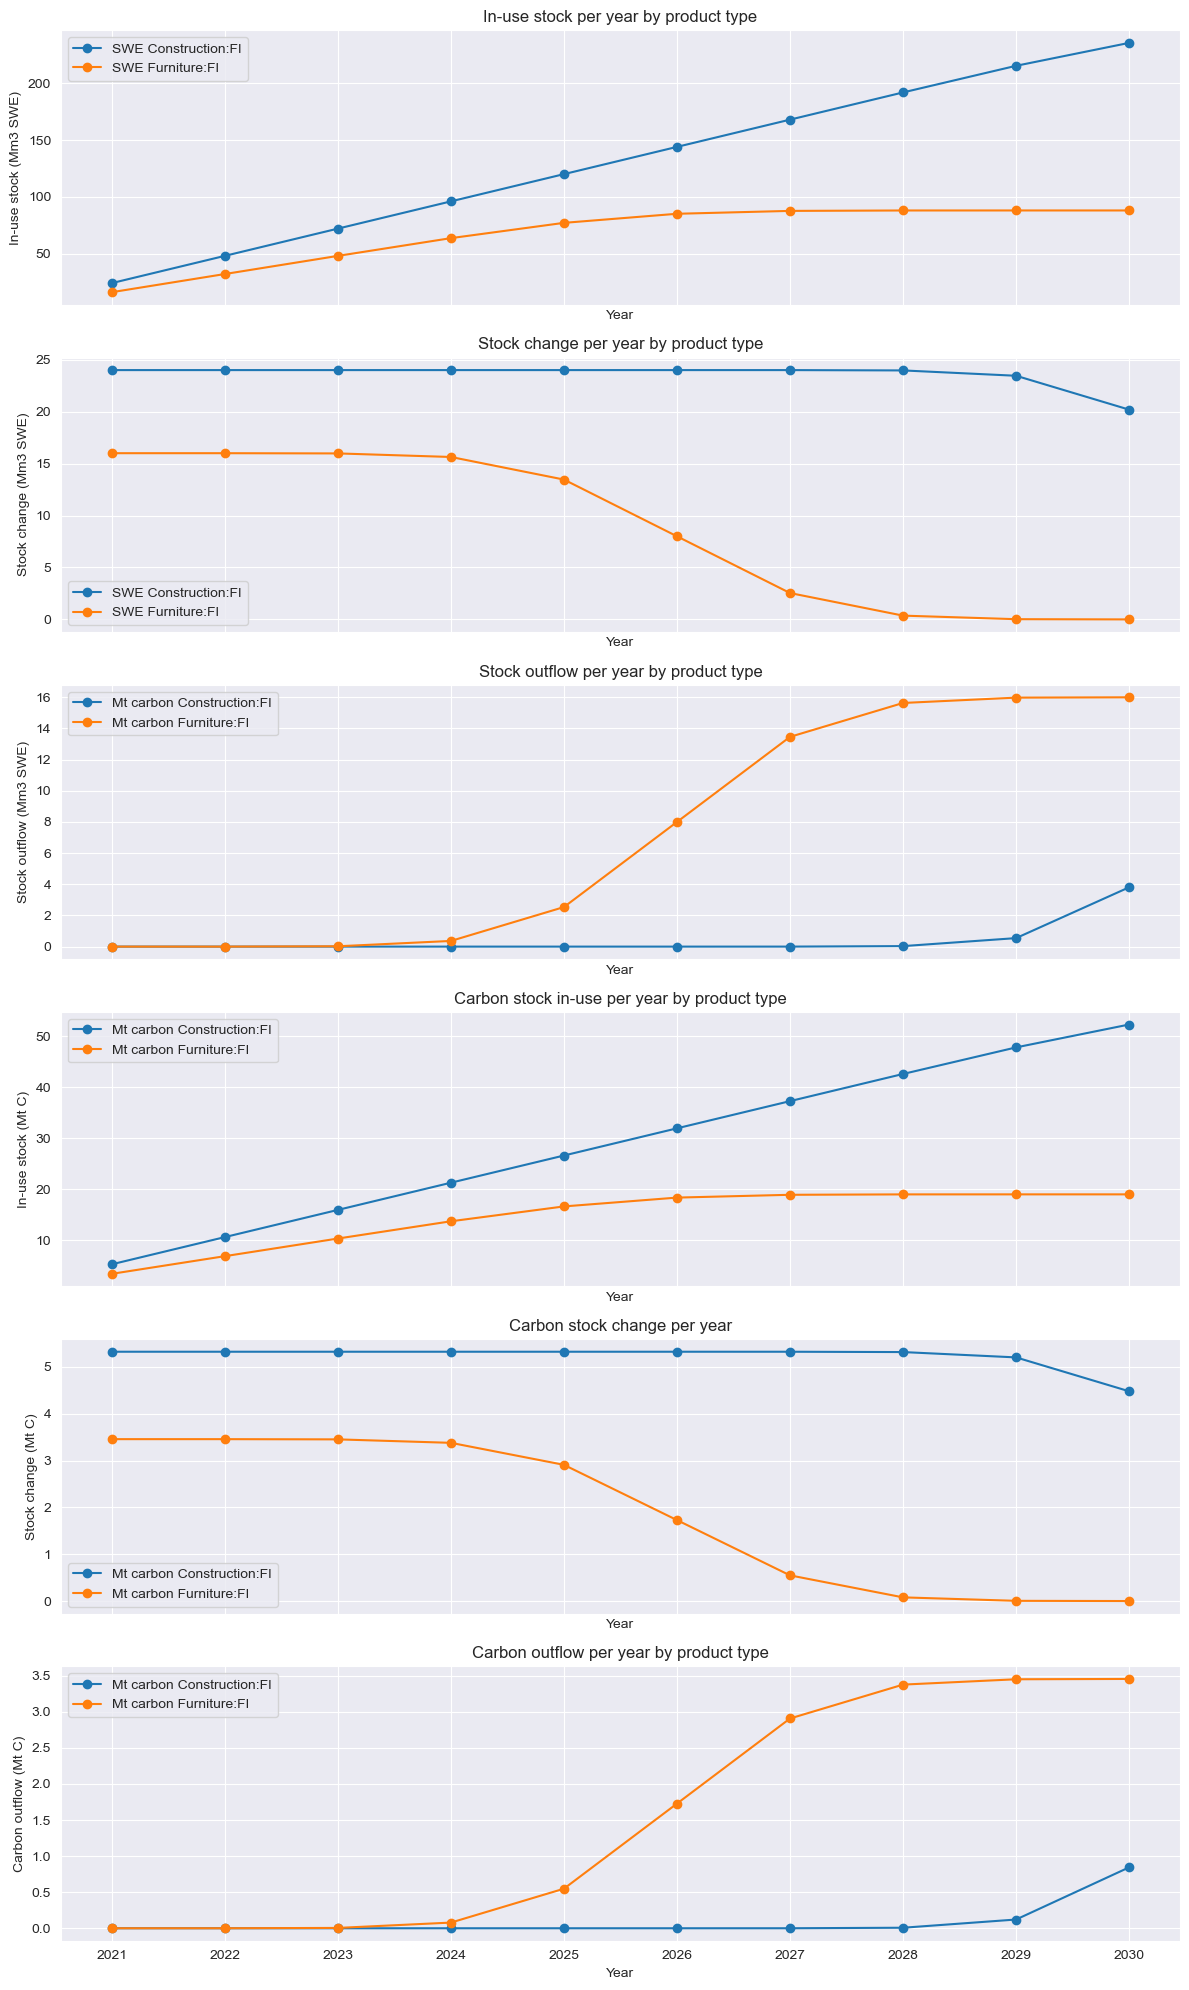

[15.99999541 31.99948867 47.97789031 63.61388819 77.07540413 85.07540413
 87.61388819 87.97789031 87.99948867 87.99999541]


In [36]:
#stock_id_to_dsm_swe and stock_id_to_dsm_carbon are dictionaries containing DynamicStockModel instances

num_years = len(years) + 1
range_x_ticks = range(min(years), max(years) + 1)

# Create a single figure with 5 subplots:
# SWE stock total, SWE stock change, Carbon stock total, Carbon stock change, Carbon outflow per year
fig, axes = plt.subplots(6, 1, sharex='all', sharey='none', figsize=(12, 20))
title_size = 12

for stock_id in stock_id_to_dsm_swe.keys():
    # SWE Stock
    dsm_swe = stock_id_to_dsm_swe[stock_id]
    swe_stock_by_cohort = dsm_swe.compute_s_c_inflow_driven()
    swe_oc = dsm_swe.compute_o_c_from_s_c()
    swe_s_c = dsm_swe.compute_s_c_inflow_driven()
    swe_stock_total = dsm_swe.compute_stock_total()
    swe_stock_change = dsm_swe.compute_stock_change()
    swe_o = dsm_swe.compute_outflow_total()

    # Carbon stock
    dsm_carbon = stock_id_to_dsm_carbon[stock_id]
    carbon_stock_by_cohort = dsm_carbon.compute_s_c_inflow_driven()
    carbon_oc = dsm_carbon.compute_o_c_from_s_c()
    carbon_s_c = dsm_carbon.compute_s_c_inflow_driven()
    carbon_stock_total = dsm_carbon.compute_stock_total()
    carbon_stock_change = dsm_carbon.compute_stock_change()
    carbon_o = dsm_carbon.compute_outflow_total()

    # Plot SWE stock total (in-use stocks)
    axes[0].plot(years, swe_stock_total, marker='o', label=f'SWE {stock_id}')
    axes[0].set_xticks(range_x_ticks)
    axes[0].set_xlabel("Year")
    axes[0].set_ylabel("In-use stock (Mm3 SWE)")
    axes[0].set_title("In-use stock per year by product type")
    axes[0].title.set_size(title_size)

    # Plot SWE stock change
    axes[1].plot(years, swe_stock_change, marker='o', label=f'SWE {stock_id}')
    axes[1].set_xticks(range_x_ticks)
    axes[1].set_xlabel("Year")
    axes[1].set_ylabel("Stock change (Mm3 SWE)")
    axes[1].set_title("Stock change per year by product type")
    axes[1].title.set_size(title_size)

        # Plot SWE outflow by cohort
    axes[2].plot(years, swe_o, marker='o', label=f'Mt carbon {stock_id}')
    axes[2].set_xticks(range_x_ticks)
    axes[2].set_xlabel("Year")
    axes[2].set_ylabel("Stock outflow (Mm3 SWE)")
    axes[2].set_title("Stock outflow per year by product type")
    axes[2].title.set_size(title_size)

    # Plot Carbon stock total (in-use stocks)
    axes[3].plot(years, carbon_stock_total, marker='o', label=f'Mt carbon {stock_id}')
    axes[3].set_xticks(range_x_ticks)
    axes[3].set_xlabel("Year")
    axes[3].set_ylabel("In-use stock (Mt C)")
    axes[3].set_title("Carbon stock in-use per year by product type")
    axes[3].title.set_size(title_size)

    # Plot Carbon stock change
    axes[4].plot(years, carbon_stock_change, marker='o', label=f'Mt carbon {stock_id}')
    axes[4].set_xticks(range_x_ticks)
    axes[4].set_xlabel("Year")
    axes[4].set_ylabel("Stock change (Mt C)")
    axes[4].set_title("Carbon stock change per year")
    axes[4].title.set_size(title_size)

    # Plot carbon outflow by cohort
    axes[5].plot(years, carbon_o, marker='o', label=f'Mt carbon {stock_id}')
    axes[5].set_xticks(range_x_ticks)
    axes[5].set_xlabel("Year")
    axes[5].set_ylabel("Carbon outflow (Mt C)")
    axes[5].set_title("Carbon outflow per year by product type")
    axes[5].title.set_size(title_size)

# Add legends to the plots
axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()
axes[4].legend()
axes[5].legend()


# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure as an SVG file
svg_file_path = "data/stock_plots_by_product.svg"
plt.savefig(svg_file_path, format='svg')

plt.show()
print(swe_stock_total)

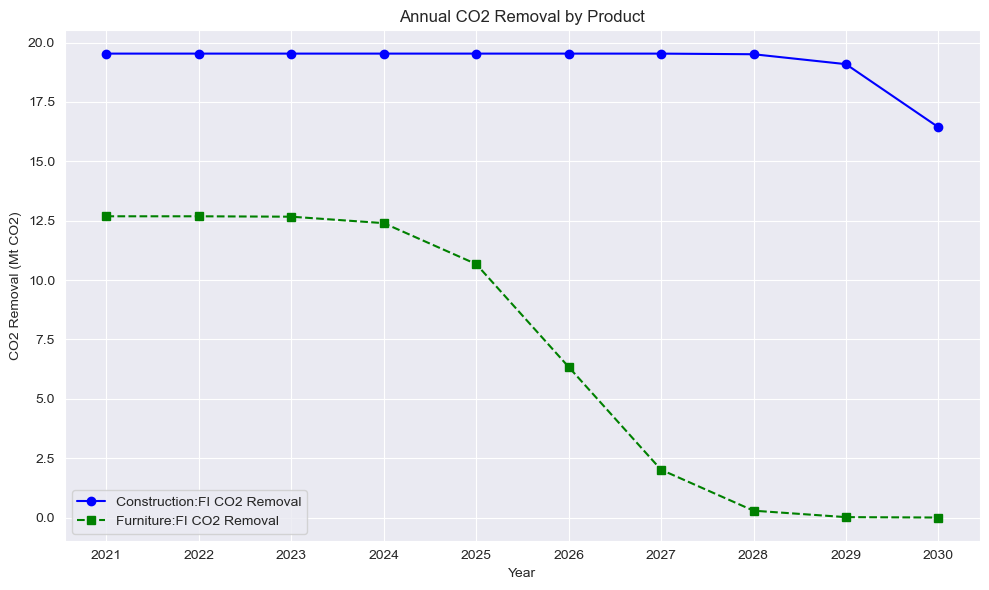

   Year  Construction:FI CO2 Removal (Mt)  Furniture:FI CO2 Removal (Mt)
0  2021                         19.532621                      12.683516
1  2022                         19.532621                      12.683118
2  2023                         19.532621                      12.666399
3  2024                         19.532621                      12.394968
4  2025                         19.532621                      10.671213
5  2026                         19.532615                       6.341760
6  2027                         19.532002                       2.012307
7  2028                         19.506254                       0.288552
8  2029                         19.088251                       0.017121
9  2030                         16.433668                       0.000402
[1.26835164e+01 1.26831183e+01 1.26663985e+01 1.23949682e+01
 1.06712129e+01 6.34176000e+00 2.01230709e+00 2.88551754e-01
 1.71214587e-02 4.01702829e-04]


In [37]:

# Conversion factor from C to CO2
conversion_factor_c_to_co2 = 3.67

# Example years (replace with your actual years)
years = [2021, 2022, 2023,2024,2025,2026,2027,2028,2029,2030]  # Replace with actual year data

# Initialize a DataFrame to store results for all stocks
results_df = pd.DataFrame({'Year': years})

# Assuming stock_id_to_dsm_swe and stock_id_to_dsm_carbon are dictionaries containing your DynamicStockModel instances

for stock_id in stock_id_to_dsm_swe.keys():
    # SWE Stock
    dsm_swe = stock_id_to_dsm_swe[stock_id]
    total_inflows_carbon_swe = np.array(dsm_swe.i)  # Replace with actual inflow method if different
    carbon_o_swe = np.array(dsm_swe.compute_outflow_total())

    # Carbon stock
    dsm_carbon = stock_id_to_dsm_carbon[stock_id]
    total_inflows_carbon_carbon = np.array(dsm_carbon.i)  # Replace with actual inflow method if different
    carbon_o_carbon = np.array(dsm_carbon.compute_outflow_total())

    # Calculate annual CO2 removal for each stock
    annual_co2_removal = (total_inflows_carbon_carbon - carbon_o_carbon) * conversion_factor_c_to_co2

    # Ensure that the lengths of all arrays match
    if len(annual_co2_removal) == len(years):
        # Add the CO2 removal data to the results DataFrame
        results_df[f'{stock_id} CO2 Removal (Mt)'] = annual_co2_removal
    else:
        print(f"Length mismatch for stock_id {stock_id}: {len(annual_co2_removal)} vs {len(years)}")

# Plot each product's CO2 removal
plt.figure(figsize=(10, 6))

# Define line styles, markers, and colors for differentiation
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for idx, stock_id in enumerate(stock_id_to_dsm_swe.keys()):
    line_style = line_styles[idx % len(line_styles)]
    marker = markers[idx % len(markers)]
    color = colors[idx % len(colors)]

    if f'{stock_id} CO2 Removal (Mt)' in results_df.columns:
        plt.plot(results_df['Year'], results_df[f'{stock_id} CO2 Removal (Mt)'], marker=marker, linestyle=line_style, color=color, label=f'{stock_id} CO2 Removal')

plt.xlabel('Year')
plt.ylabel('CO2 Removal (Mt CO2)')
plt.title('Annual CO2 Removal by Product')
plt.grid(True)
plt.xticks(years)
plt.legend()
plt.tight_layout()

# Save the figure as an SVG file
svg_file_path = "data/annual_co2_removal_by_product.svg"
plt.savefig(svg_file_path, format='svg')

plt.show()

print(results_df)
print(annual_co2_removal)

In [38]:
# *****************************************************
# * Step 10: Visualize the flow graph as Sankey graph *
# *****************************************************

# Color mappings
process_transformation_stage_colors = dict()
process_transformation_stage_colors["Source"] = "#7DDA60"
process_transformation_stage_colors["First"] = "#eb5e34"
process_transformation_stage_colors["Second"] = "#8c76cf"
process_transformation_stage_colors["Third"] = "#5BAA11"
process_transformation_stage_colors["VAM"] = "#3281db"
process_transformation_stage_colors["RoW"] = "#61b053"  # Rest of the world
process_transformation_stage_colors["EoL"] = "#EFC3CA"  # Brown
process_transformation_stage_colors["by_prod"] = "#DFC57B"  # gold
process_transformation_stage_colors["Virtual"] = "#707070"

#
virtual_process_graph_labels = dict()
virtual_process_graph_labels["VP_P2:EU"] = "Unreported flow from P2"
virtual_process_graph_labels["VP_P3:EU"] = "Unreported flow from P3"

# Virtual Process and virtual Flow colors
visualizer_params = {
    # User can hide processes in Sankey graph that have total inflows less than this value
    # This value cannot be changed now in the Sankey graph
    "small_node_threshold": 5,

    # Dictionary to define labels for virtual flows
    # If dictionary contains label for the virtual process then that is used,
    # otherwise the virtual process ID is used
    "virtual_process_graph_labels": virtual_process_graph_labels,

    # Dictionary to define color of process by the process transformation stage name
    # All must be provided as a RGB hex string, prefixed by character '#'
    # Usage example: { "Source": "#707070" }
    "process_transformation_stage_colors": process_transformation_stage_colors,

    # How transparent flows are (0.0 = invisible, 1.0 = fully opaque)
    "flow_alpha": 0.75,

    # Color for virtual process
    "virtual_process_color": "rgba(0.3, 0.3, 0.3, 0.6)",

    # Color for virtual flows
    "virtual_flow_color": "rgba(0.5, 0.5, 0.5, 0.5)",
}

visualizer = DataVisualizer()
visualizer.build(flowsolver, visualizer_params)
visualizer.show()